<a href="https://colab.research.google.com/github/HyeongChanHam/Lung_Cancer_detection/blob/master/U_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import numpy as np
import random
import sys
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.io import imread, imshow

from tqdm import tqdm

from skimage.transform import resize

In [0]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
!ls sample_data

anscombe.json		      mnist_test.csv
california_housing_test.csv   mnist_train_small.csv
california_housing_train.csv  README.md


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
PATH = "gdrive/My Drive/lung_cancer/"

In [0]:
img_path = PATH+'image/'
label_path = PATH+'mask/'

In [0]:
img_ids = next(os.walk(img_path))[2]
label_ids = next(os.walk(label_path))[2]
img_ids.sort()
label_ids.sort()
print(len(img_ids))
print(len(label_ids))

742
742


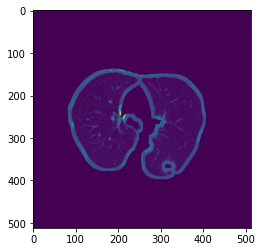

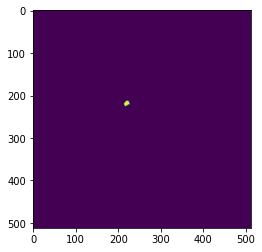

In [0]:
# i=5
# img = imread(img_path + img_ids[i])
# plt.imshow(img)
# plt.show()
# label = imread(label_path + label_ids[i])
# plt.imshow(label)
# plt.show()


In [0]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 1

In [0]:
X_train = np.zeros((len(img_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(img_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(img_ids), total=len(img_ids)):
    path = img_path + id_
    img = np.expand_dims(imread(path),axis=2)
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img

for n, id_ in tqdm(enumerate(label_ids), total=len(label_ids)):
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=np.bool)
    path = label_path + id_
    label = np.expand_dims(imread(path), axis=2)
    mask = resize(label, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    Y_train[n] = mask

Getting and resizing train images and masks ... 


100%|██████████| 742/742 [04:58<00:00,  2.49it/s]


/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


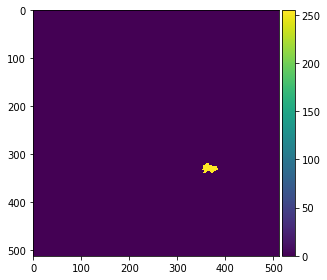

In [0]:
# imshow('gdrive/My Drive/lung_cancer/mask/mask_LIDC-IDRI-0058_2_3.png')
# print(img_path + img_ids[0])
# gdrive/My Drive/lung_cancer/image/image_LIDC-IDRI-0001_0_0.png

image_LIDC-IDRI-0003_1_1.png


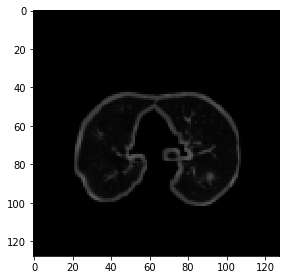

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


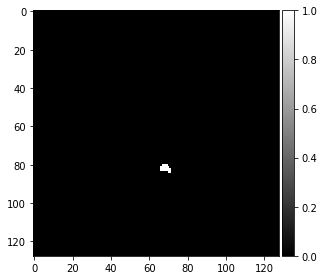

In [0]:
# ix = random.randint(0, len(one_ids))
# print(img_ids[ix])
# imshow(X_train[ix][:,:,0])
# plt.show()
# imshow(Y_train[ix][:,:,0],cmap=plt.cm.gray)
# plt.show()

In [0]:
# Define IoU metric
from keras import backend as K
# def iou(y_true, y_pred):
#     y_true = tf.cast(y_true, tf.bool)
#     intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
#     union = K.sum(y_true, -1) + K.sum(y_pred, -1) - intersection
#     iou = (intersection) / (union)
#     return iou


# def iou_loss(y_true, y_pred):
#     intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
#     union = K.sum(y_true, -1) + K.sum(y_pred, -1) - intersection
#     iou = (intersection) / (union)
#     return -iou

def iou(y_true, y_pred):
    intersection = (y_true[:,:,0]*y_pred[:,:,0]).sum()
    union =y_true[:,:,0].sum() + y_pred[:,:,0].sum() - intersection
    return intersection/union



# def iou(y_true, y_pred):
#     intersection = tf.reduce_sum(y_true[:,:,0]*y_pred[:,:,0])
#     union =tf.reduce_sum(y_true[:,:,0]) + tf.reduce_sum(y_pred[:,:,0]) - intersection
#     return intersection/union

Using TensorFlow backend.


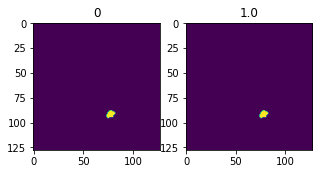

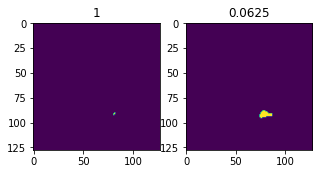

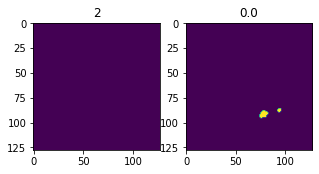

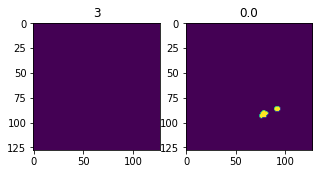

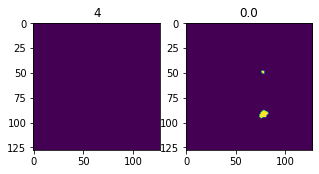

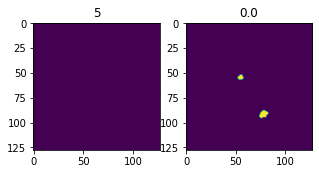

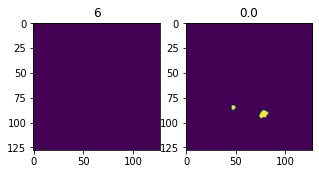

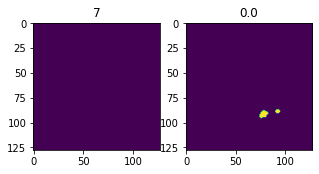

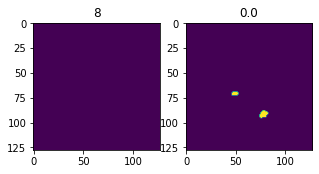

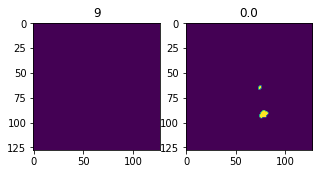

In [0]:
# # print(mean/_iou(Y_train[0], Y_train[0]))
# for i in range(10):
#     fig, ax = plt.subplots(1,2,figsize=(5,3))
#     ax[0].imshow((Y_train[0] * Y_train[i])[:,:,0])
#     # plt.show()
#     ax[0].title.set_text(i)
#     ax[1].imshow((Y_train[0] + Y_train[i])[:,:,0])
#     # plt.show()
#     intersection = (Y_train[0] * Y_train[i]).sum()
#     union = (Y_train[0].sum()) + (Y_train[i].sum()) - intersection
#     ax[1].title.set_text(intersection/union)
#     plt.show()

In [0]:
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint


inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
adam = Adam(lr = 0.0005, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=adam, loss='binary_crossentropy')

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 128, 128, 1)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 128, 128, 16) 160         lambda_3[0][0]                   
__________________________________________________________________________________________________
dropout_19 (Dropout)            (None, 128, 128, 16) 0           conv2d_39[0][0]                  
____________________________________________________________________________________________

In [0]:
earlystopper = EarlyStopping(patience=10, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2020-4.h5', verbose=1, save_best_only=True)
with tf.device('/device:GPU:0'):
    results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=128, epochs=100, 
                    callbacks=[earlystopper, checkpointer])

Train on 667 samples, validate on 75 samples
Epoch 1/100
667/667 [==============================] - 3s 5ms/step - loss: 0.4222 - val_loss: 0.0453

Epoch 00001: val_loss improved from inf to 0.04526, saving model to model-dsbowl2020-4.h5
Epoch 2/100
667/667 [==============================] - 2s 3ms/step - loss: 0.0558 - val_loss: 0.0269

Epoch 00002: val_loss improved from 0.04526 to 0.02690, saving model to model-dsbowl2020-4.h5
Epoch 3/100
667/667 [==============================] - 2s 3ms/step - loss: 0.0274 - val_loss: 0.0181

Epoch 00003: val_loss improved from 0.02690 to 0.01814, saving model to model-dsbowl2020-4.h5
Epoch 4/100
667/667 [==============================] - 2s 3ms/step - loss: 0.0220 - val_loss: 0.0213

Epoch 00004: val_loss did not improve from 0.01814
Epoch 5/100
667/667 [==============================] - 2s 3ms/step - loss: 0.0262 - val_loss: 0.0219

Epoch 00005: val_loss did not improve from 0.01814
Epoch 6/100
667/667 [==============================] - 2s 3ms/ste

In [0]:
# Predict on train, val and test
# model = load_model('model-dsbowl2020-4.h5')
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.25).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

75/75 [==============================] - 0s 958us/step


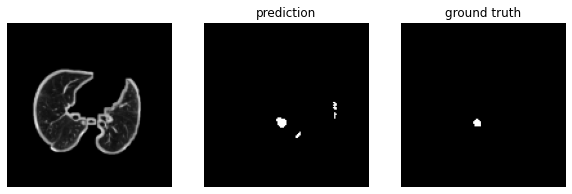

iou :  0.3125


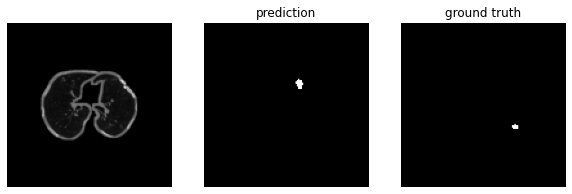

iou :  0.0


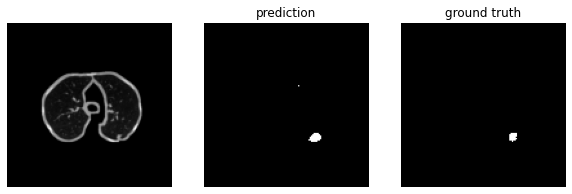

iou :  0.6346153846153846


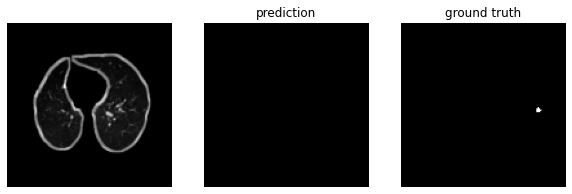

iou :  0.0


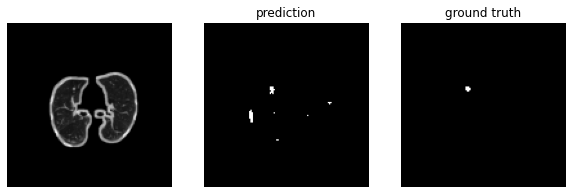

iou :  0.16981132075471697


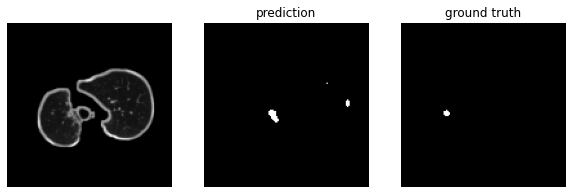

iou :  0.0


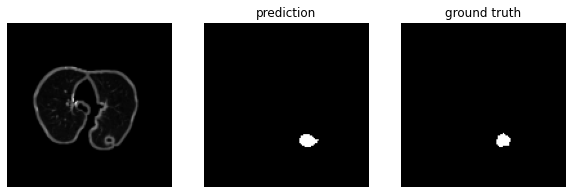

iou :  0.7431192660550459


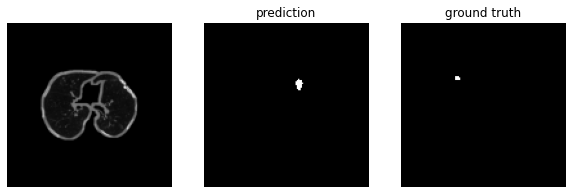

iou :  0.0


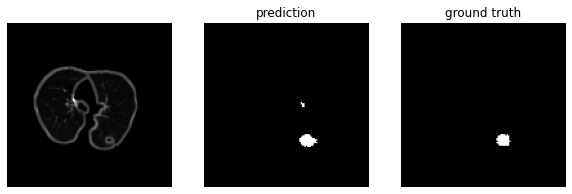

iou :  0.6944444444444444


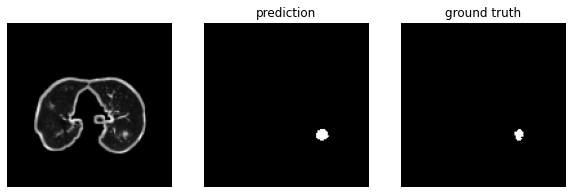

iou :  0.6818181818181818
[0.44594595 0.62068966 0.69166667 0.68461538 0.75       0.74311927
 0.69444444 0.48739496 0.41176471 0.48648649 0.70149254 0.68
 0.66666667 0.68131868 0.78021978 0.73913043 0.81818182 0.71910112
 0.75641026 0.81081081 0.61538462 0.74603175 0.81818182 0.84090909
 0.675      0.54545455 0.60714286 0.39285714 0.45833333 0.58139535
 0.86842105 0.82222222 0.7755102  0.77358491 0.69354839 0.6779661
 0.         0.         0.14814815 0.56164384 0.41509434 0.37837838
 0.37113402 0.41666667 0.40625    0.68181818 0.7027027  0.78378378
 0.83333333 0.81578947 0.82258065 0.         0.04761905 0.10144928
 0.         0.21428571 0.26984127 0.26086957 0.12280702 0.
 0.         0.         0.         0.25       0.44736842 0.45333333
 0.51851852 0.63529412 0.61445783 0.73333333 0.71910112 0.70731707
 0.63076923 0.55       0.         0.         0.         0.
 0.         0.         0.         0.0952381  0.         0.03472222
 0.         0.         0.         0.         0.         0.


In [0]:
iou_vec = np.array([])
for i in range(10):
    ix = random.randint(0, len(Y_train))
    fig, ax = plt.subplots(1,3,figsize=(10,6))
    ax[0].imshow(X_train[ix][:,:,0],cmap='gray')
    ax[0].axis('off')
    ax[1].imshow(np.squeeze(preds_train_t[ix][:,:,0]),cmap='gray')
    ax[1].title.set_text("prediction")
    ax[1].axis('off')
    ax[2].imshow(np.squeeze(Y_train[ix][:,:,0]),cmap='gray')
    ax[2].title.set_text("ground truth")
    ax[2].axis('off')
    plt.show()
    print("iou : ",iou(preds_train_t[ix].astype(np.bool),Y_train[ix]))
    # print(preds_train_t[ix].astype(np.bool).shape)
    # preds_train_t[ix].astype(np.bool) + 
for i in range(len(preds_train_t)):
    iou_vec = np.append(iou_vec, iou(preds_train_t[i].astype(np.bool),Y_train[i]))
print(iou_vec)
print(iou_vec.mean())

In [0]:
np.where(iou_vec>0,1,0).mean()

0.8920539730134932